In [1]:
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import seaborn                  as sns
import iirsBenchmark.regressors as regressors

import Auxiliary
import re

from IPython.display  import display
from CriticalDiagrams import draw_cd_diagram


# Setting everything up
Auxiliary.create_global_file_path_variables(results_path='../../results')
Auxiliary.set_mpl_sns_params(abnt=False)

%matplotlib inline

analyzed_path = f'../post hoc analysis files/' # Where to save the plots

## Post processing global explanation quality

In [2]:
def post_processing_global_explanation_quality(*, train_or_test, comparison_metric):
    """Returns an dataframe where each row is an explainer and each column is a 
    regression method. The value of the cells are the median observed for all
    data sets.
    
    comparison_metric should be a function that takes two explanation arrays
    and return a single value (can be vectorized, and the arrays should be 
    two dimensional, each line corresponding to a explanation and each row
    corresponding to a variable). The comparison_metric will be used to
    compare explanations for the original feynman equation and the regressor
    explanation using the same explainer.
    """
    
    # Feynman is used as ground truth here
    if train_or_test == 'train':
        df_feynman = pd.read_csv(f'{Auxiliary.global_path_train}Feynman_regressor.csv')
    else:
        df_feynman = pd.read_csv(f'{Auxiliary.global_path_test}Feynman_regressor.csv')
        
    df_feynman['explanation'] = df_feynman['explanation'].map(Auxiliary.convert_to_array_of_floats)
    df_feynman.dropna(inplace=True, axis=0)
    
    data = []
    for regressor in regressors.__all__ + ['Operon_regressor']:
        
        if train_or_test == 'train':
            df_regressor = pd.read_csv(f'{Auxiliary.global_path_train}{regressor}.csv')
        else:
            df_regressor = pd.read_csv(f'{Auxiliary.global_path_test}{regressor}.csv')

        df_regressor['explanation'] = df_regressor['explanation'].map(
            Auxiliary.convert_to_array_of_floats)
        
        df_regressor.dropna(inplace=True, axis=0)

        # Merging ground truth and explanations data frames   
        df_merged = pd.merge(df_regressor, df_feynman,
            on=["dataset", 'explainer'], how='left', suffixes=(None, '_feynman'))

        # If a explainer is applicable for only one of the regressor/feynman,
        # there will be nans in the explanations for it
        df_merged.dropna(subset=['explanation', 'explanation_feynman'], inplace=True)

        # Defining how the calculation of the metric should be handled
        def calculate_safe_metric(row):
            try: 
                return comparison_metric(
                    row['explanation'].reshape(1, -1),
                    row['explanation_feynman'].reshape(1, -1) )

            except Exception as e:
                print(e, row['explanation'], row['explanation_feynman'])

                return np.nan

        # applying the metric row-wise
        df_merged[comparison_metric.__name__] = df_merged.apply(calculate_safe_metric, axis=1)
        
        # Improving the name of explainers
        df_merged['explainer'] = df_merged['explainer'].map(lambda x: x.replace('_explainer', ''))

        df_merged = df_merged.groupby(['dataset', 'explainer']).mean().reset_index(level=[0,1])

        df_pivoted = df_merged.pivot(
            index='dataset', columns='explainer')[comparison_f.__name__]
        
        # Making extreme outliers become nan
        # (which will be ignored when calculating the median)
        df_pivoted = df_pivoted[df_pivoted < 5000]  

        new_df = df_pivoted.median(axis=0, skipna=True)
        new_df.name = regressor.replace('_regressor', '')
        
        data.append(new_df)

    # Concatenating and returning the final dataframe
    return pd.concat(data, axis=1)

Cosine_similarity


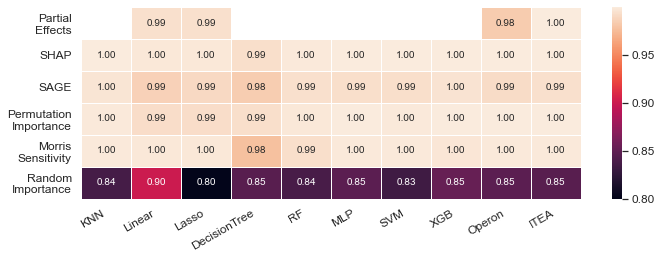

RMSE


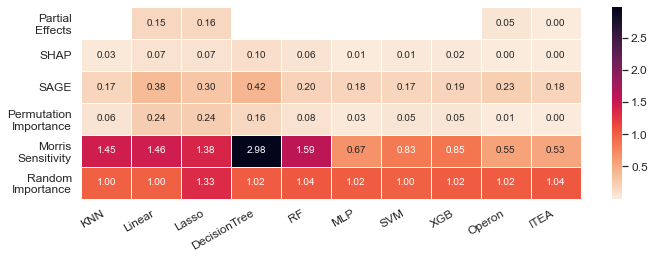

NMSE


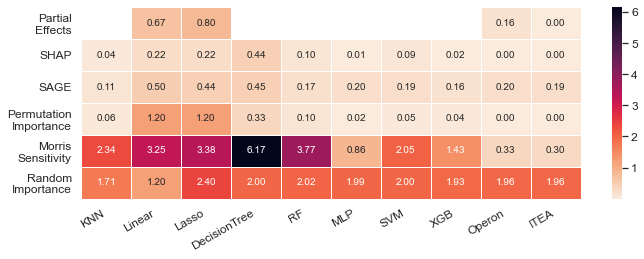

In [3]:
# We use reverse colormaps in cases where smaller values are better,
# so there is a convention in the color: lighter is better
comparisons_and_maps = [
    (Auxiliary.Cosine_similarity, sns.color_palette("rocket",   as_cmap=True)), 
    (Auxiliary.RMSE,              sns.color_palette("rocket_r", as_cmap=True)),
    (Auxiliary.NMSE,              sns.color_palette("rocket_r", as_cmap=True))
]

for comparison_f, cmap in comparisons_and_maps:
    print(comparison_f.__name__)
    
    all_regressors = post_processing_global_explanation_quality(
        train_or_test='test', comparison_metric=comparison_f)

    # selecting and sorting the regressors
    all_regressors = all_regressors[
        ['KNN', 'Linear', 'Lasso', 'DecisionTree', 'RF', 'MLP', 'SVM', 'XGB', 'Operon', 'ITEA']
    ].T
    
    # selecting and sorting the explainers
    all_regressors = all_regressors[
        ['PartialEffects', 'SHAP', 'SAGE', 'PermutationImportance', 'MorrisSensitivity', 'RandomImportance']
    ]
    
    # Adding line breaks in explainer names
    all_regressors.columns = ['\n'.join(re.findall('[A-Z]+[a-z]*', col)) for col in all_regressors.columns]

    f, ax = plt.subplots(figsize=(10, 3.70))
    
    plot = sns.heatmap(all_regressors.T, linewidths=.5, ax=ax,
        annot=True, fmt=".2f",    # us format
        #annot=all_regressors.T.applymap(lambda x: f"{x:.2f}".replace('.',',')).values, fmt='', # pt-br format
        cmap = cmap,
    )
    
    plt.xticks(rotation=30, ha='right') 
    
    plt.tight_layout()
    plt.savefig(f'{analyzed_path}{comparison_f.__name__}_global_heatmap.pdf', bbox_inches='tight')
    plt.show()